<a href="https://colab.research.google.com/github/Pulin98/Statistical-Learning-and-Neural-Network/blob/main/lab3_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation and neural network quantization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here are all the import statements needed for all the exercises

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
%load_ext tensorboard
import numpy as np
import matplotlib.pyplot as plt

! pip install tensorflow_model_optimization
import tensorflow_model_optimization as tfmot
import numpy as np


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 2.2 MB/s eta 0:00:00


Loading the Sentinel 2 dataset. Images and labels are padded to be 256x256 in size and normalized by their maximum value. 40 images are used for the train partition (X_train, Y_train) and 10 for testing (X_test, Y_test)

Shape of channels_to_visualize: (256, 256, 12)


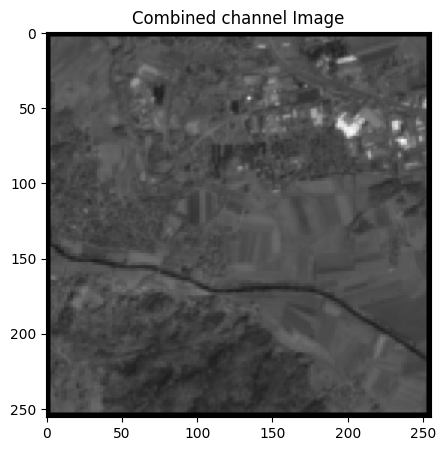

In [ ]:
# Load the Sentinel 2 dataset
loaded = np.load('/content/drive/MyDrive/Colab Notebooks 2023 2024/LAB3_NN/sentinel2.npz')
X = loaded['X'].astype(np.float32)
Y = loaded['Y'].astype(np.float32)
X = np.pad(X, ((0, 0), (3, 3), (3, 3), (0, 0)))
Y = np.pad(Y, ((0, 0), (3, 3), (3, 3), (0, 0)))
X_train = X[:40] / np.max(X[:40])
X_test = X[40:] / np.max(X[:40])
Y_train = Y[:40]
Y_test = Y[40:]


image = X_train[2]

print("Shape of channels_to_visualize:", image.shape)

# Display all channels in the first image
plt.figure(figsize=(30, 5))
#for i in range(image.shape[2]):
    #plt.subplot(1, image.shape[2], i + 1)
    #plt.imshow(image[:, :, i], cmap='gray')
    #plt.title(f'Channel {i + 1}')
    #plt.axis('off')
#plt.show()

# Compute the mean across channels
combined_channel_image = np.mean(image, axis=-1)

# Display the combined image
plt.imshow(combined_channel_image, cmap='gray')
plt.title('Combined channel Image')
plt.show()



**[TODO]** Implement the U-net neural network for segmentation as drawn in the lab document.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation

def unet_model(input_size=(256, 256, 12)):
    inputs = Input(input_size)

    # Encoder Path
    conv1 = Conv2D(filters=64, kernel_size=3, padding='same', strides=1)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1_2 = Conv2D(filters=64, kernel_size=3, padding='same', strides=1)(conv1)
    conv1_2 = BatchNormalization()(conv1_2)
    conv1_2 = Activation('relu')(conv1_2)

    conv2 = Conv2D(filters=128, kernel_size=3, padding='same', strides=2)(conv1_2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)

    conv3 = Conv2D(filters=256, kernel_size=3, padding='same', strides=2)(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(filters=256, kernel_size=3, padding='same', strides=1)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    up1 = UpSampling2D(size=(2, 2))(conv3)

    merge1 = concatenate([conv2, up1], axis=3)
    conv4 = Conv2D(filters=256, kernel_size=3, padding='same', strides=1)(merge1)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    up2 = UpSampling2D(size=(2, 2))(conv4)

    merge2 = concatenate([conv1_2, up2], axis=3)
    conv5 = Conv2D(filters=128, kernel_size=3, padding='same', strides=1)(merge2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv_final = Conv2D(filters=1, kernel_size=1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=conv_final)
    return model

# Create the model and print shapes
model = unet_model()

**[TODO]** Compile and train the model (might take some time...)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation


# Define the model
model = unet_model()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=2, epochs=100)

**[TODO]** Test the model on the test set and measure the accuracy.

In [ ]:
# Test the model on the test set and measure accuracy
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

train_loss, train_accuracy = model.evaluate(X_train, Y_train)

print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

# Effettua le predizioni sul set di test
predictions = model.predict(X_test)

# Applica la soglia per ottenere le etichette binarie (0 o 1)
binary_predictions = (predictions > 0.5).astype(np.uint8)

# Calcola l'insieme unico di valori nelle predizioni binarie
unique_values = np.unique(binary_predictions)

# Stampa gli unici valori presenti nelle predizioni binarie
print("Valori unici nelle predizioni binarie:", unique_values)

count_zeros = np.count_nonzero(binary_predictions == 0)
count_ones = np.count_nonzero(binary_predictions == 1)

# Stampa i risultati
print("Numero di zeri nel test:", count_zeros)
print("Numero di uni nel test:", count_ones)

# Effettua le predizioni sul set di train
predictions = model.predict(X_train)

# Applica la soglia per ottenere le etichette binarie (0 o 1)
binary_predictions = (predictions > 0.5).astype(np.uint8)

# Calcola l'insieme unico di valori nelle predizioni binarie
unique_values = np.unique(binary_predictions)

# Stampa gli unici valori presenti nelle predizioni binarie
print("Valori unici nelle predizioni binarie:", unique_values)

count_zeros = np.count_nonzero(binary_predictions == 0)
count_ones = np.count_nonzero(binary_predictions == 1)

# Stampa i risultati
print("Numero di zeri nel train:", count_zeros)
print("Numero di uni nel train:", count_ones)

1/1 [==============================] - 1s 592ms/step - loss: 0.1770 - accuracy: 0.9296
Test Loss: 0.1770
Test Accuracy: 92.96%
2/2 [==============================] - 1s 162ms/step - loss: 0.4042 - accuracy: 0.9030
Train Loss: 0.4042
Train Accuracy: 90.30%
1/1 [==============================] - 0s 268ms/step
Valori unici nelle predizioni binarie: [0 1]
Numero di zeri nel test: 520682
Numero di uni nel test: 134678
2/2 [==============================] - 1s 504ms/step
Valori unici nelle predizioni binarie: [0 1]
Numero di zeri nel train: 2329422
Numero di uni nel train: 292018


1/1 [==============================] - 0s 142ms/step
(256, 256)


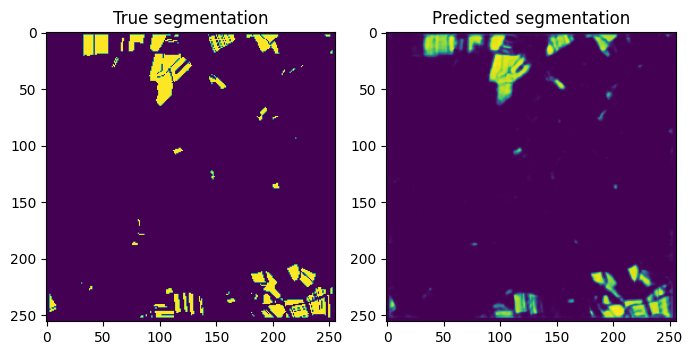

In [ ]:
test_pred = model.predict(X_test)

# Comparing the results
img_index = 2
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 2)
plt.title('True segmentation')
plt.imshow(Y_test[img_index, :, :])
plt.subplot(1, 3, 3)
plt.title('Predicted segmentation')
#plt.imshow(test_pred[img_index, :, :])
x = np.squeeze(test_pred[img_index, :, :])
plt.imshow(x)
print(x.shape)
plt.tight_layout()
plt.show()

**[TODO]** Convert model to TFLite with 8-bit weight quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converted_model = converter.convert()
with open("converted_model.tflite", "wb") as f:
  f.write(converted_model)

**[TODO]** Test the accuracy of the quantized model by writing your own "evaluate" function. Remember that TFLite interpreter can only process one sample at a time, not a batch.

In [ ]:
def evaluate(interpreter, val_images, val_labels):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    correct_predictions = 0
    total_pixels = 256*256*10
    total_samples = val_images.shape[0]

    correct_predictions=0


    for tt in range(total_samples):
        test_image = val_images[tt:(tt + 1)]
        test_label = val_labels[tt:(tt + 1)]
        interpreter.set_tensor(input_index, test_image)

        interpreter.invoke()
        output = interpreter.get_tensor(output_index)
        output = output.squeeze(0)
        output = output.squeeze(2)

        y_pred_flat = output.flatten()


        test_label = test_label.squeeze(0)
        test_label = test_label.squeeze(2)

        y_true_flat = test_label.flatten()

        predicted_class = (y_pred_flat > 0.5).astype(int)
        true_class = (y_true_flat > 0.5).astype(int)

        for i in range(len(predicted_class)):
          if predicted_class[i] == true_class[i]:
            correct_predictions +=1

    accuracy = correct_predictions / total_pixels

    return accuracy

interpreter = tf.lite.Interpreter(model_content = converted_model)
interpreter.allocate_tensors()
X_test = X[40:] / np.max(X[:40])

accuracy = evaluate(interpreter, X_test, Y_test)
print(f"accuracy = {accuracy * 100:.2f}%")

accuracy = 92.96%


**[TODO]** Finetune the Keras model using quantization-aware training and measure the accuracy on the test set after actually quantizing it

In [ ]:
!pip install tensorflow_model_optimization
import tensorflow_model_optimization as tfmot

quant_aware_model = tfmot.quantization.keras.quantize_model(model)
quant_aware_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
quant_aware_model.fit(X_train,Y_train, validation_data=(X_test, Y_test), batch_size=2, epochs=100)

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_aware_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content = quantized_aware_model)
interpreter.allocate_tensors()
X_test = X[40:] / np.max(X[:40])

accuracy = evaluate(interpreter, X_test, Y_test)
print(f"accuracy = {accuracy * 100:.2f}%")